<a href="https://colab.research.google.com/github/juanfes517/CO2_Emissions_Prediction/blob/main/03%20-%20modelos%20e%20iteraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from pandas.core.frame import DataFrame
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import os

# 1. Carga del Dataset

In [ ]:
# Define las variables de entorno con tus credenciales de Kaggle
os.environ['KAGGLE_USERNAME'] = 'juanescobar15'
os.environ['KAGGLE_KEY'] = 'ae647c4829821fd4d2514ca445632682'

# Instala la API de Kaggle
!pip install kaggle

# Descargar los datos de la competición "Playground Series - S3E20" desde Kaggle
!kaggle competitions download -c playground-series-s3e20

# Descomprimir el archivo ZIP descargado
!unzip -o playground-series-s3e20.zip


 84% 41.0M/48.9M [00:01<00:00, 25.0MB/s]
100% 48.9M/48.9M [00:01<00:00, 33.5MB/s]
Archive:  playground-series-s3e20.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
dtr = pd.read_csv("train.csv")
dts = pd.read_csv("test.csv")
dtr.shape, dts.shape

((79023, 76), (24353, 75))

# 2. Métodos de limpieza

Elimina todas las filas en las que la variable de respuesta exceda un límite especificado.

In [ ]:
def removeRows(limit, df):
  return df[df['emission'] < limit]

Elimina las columnas que contengan un porcentaje de datos faltantes superior al valor especificado como parámetro.

In [ ]:
def dropHighMissing(percent, df):
  umbral = len(df) * percent
  return df.dropna(thresh=umbral, axis=1)

Limpieza de datos faltantes mediante el uso de una distribución normal de muestra.

In [ ]:
def fillWithNormalDistribution(df):
  for columna in df.columns:
    Agrupacion_lati = df.groupby('latitude')

    if pd.api.types.is_numeric_dtype(df[columna]):
      faltantes = df[columna].isna()
      mu = df.loc[~faltantes, columna].mean()
      std = df.loc[~faltantes, columna].std()
      sample = np.random.normal(mu, std, len(df[faltantes]))
      df.loc[faltantes, columna] = sample

  return df

Realiza la discretización en el 10% de las columnas con la menor correlación.

In [ ]:
def discretizeColumns(df, columnas_a_discretizar):
  for colum in columnas_a_discretizar:
    num_bins = 5
    df[colum] = pd.cut(df[colum], bins=num_bins, labels=False)

  return df

Aplica los métodos de limpieza a un dataset

In [ ]:
def clean_dataset(df, columnas_a_discretizar):
  df = dropHighMissing(0.5, df)
  df = fillWithNormalDistribution(df)
  df = discretizeColumns(df, columnas_a_discretizar)
  df = df.drop(labels=["ID_LAT_LON_YEAR_WEEK"], axis=1)
  return df

# 3. Limpieza de los datos

In [ ]:
correlation_matrix = dtr.corr()
columnas_a_discretizar = correlation_matrix['emission'].abs().nsmallest(8).index

dtr = clean_dataset(dtr, columnas_a_discretizar)
dts = clean_dataset(dts, columnas_a_discretizar)
dtr.shape, dts.shape

<ipython-input-14-5c3661e4a63c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dtr.corr()
<ipython-input-7-93b149cc7513>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colum] = pd.cut(df[colum], bins=num_bins, labels=False)
<ipython-input-7-93b149cc7513>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colu

((79023, 68), (24353, 67))

# 4. Entrenamiento y predicción

In [ ]:
X = dtr[dtr.columns[:-1]]
y = dtr["emission"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, y_train.shape

((55316, 67), (55316,))

## 4.1. Selección de mejores modelos

Polinomial

In [ ]:
degree = 2

model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Ajuste
model.fit(X_train, y_train)
# predicciones
y_pred = model.predict(X_test)

# Calcular el RMSE
rmse_polinomio = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"El error (RMSE) de test es: {rmse_polinomio}")

El error (RMSE) de test es: 134.55028682943706


Regresión lineal

In [ ]:
modell = LinearRegression()

# Ajuste
modell.fit(X_train, y_train)
# predicciones
y_pred = modell.predict(X_test)

# Calcular el RMSE
rmse_lineal = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"El error (RMSE) de test es: {rmse_lineal}")

El error (RMSE) de test es: 134.74020375616033


Gradient Boosting model

In [ ]:
modelG = GradientBoostingRegressor()

modelG.fit(X_train, y_train)
y_pre=modelG.predict(X_test)
rmse_gradient = np.sqrt(mean_squared_error(y_test, y_pre))
print(f"El error (RMSE) de test es: {rmse_gradient}")

El error (RMSE) de test es: 63.93649830445777


Random forest

In [ ]:
modelrf = RandomForestRegressor(random_state=42)

modelrf.fit(X_train, y_train)
y_predict = modelrf.predict(X_test)

rmse_randomforest = np.sqrt(mean_squared_error(y_test, y_predict))

print(f"El error (RMSE) de test es: {rmse_randomforest}")

El error (RMSE) de test es: 24.00540710406229


XBGRegressor

In [ ]:
model_xb = XGBRegressor()
model_xb.fit(X_train, y_train)

y_p = model_xb.predict(X_test)

rmse_xbregressor= np.sqrt(mean_squared_error(y_test, y_p))

print(f"El error (RMSE) de test es: {rmse_xbregressor}")

El error (RMSE) de test es: 25.103963731562825


Mejor RMSE

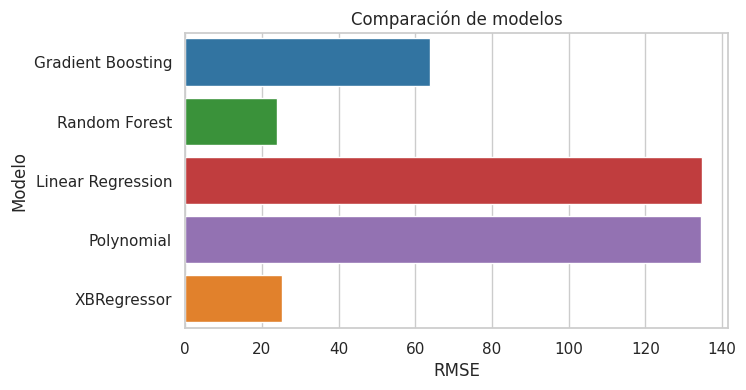

In [ ]:
rmse_values = [rmse_gradient, rmse_randomforest, rmse_lineal, rmse_polinomio, rmse_xbregressor]

# comparación de modelos
df_comparacion = pd.DataFrame({
    'modelo': ['Gradient Boosting', 'Random Forest', 'Linear Regression', 'Polynomial', 'XBRegressor'],
    'test_rmse': rmse_values
})
colores = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e']
sns.set(style="whitegrid")
plt.figure(figsize=(7, 3.84))
sns.barplot(x="test_rmse", y="modelo", data=df_comparacion, palette=colores)
plt.xlabel('RMSE')
plt.ylabel('Modelo')
plt.title('Comparación de modelos')

plt.show()

## 4.2. Mejores modelos supervisados

### 4.2.1. XGBRegressor

Busqueda de Mejores hiperparametros usando GridSearchCV

In [ ]:
# Crear el modelo XGBRegressor
model = XGBRegressor()

scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

param_tuning = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators' : [100, 200, 500],
    'objective': ['reg:squarederror']
}

gsearch = GridSearchCV(estimator = model,
                      param_grid = param_tuning,
                      scoring=scorer,
                      cv = 2,
                      n_jobs = -1,
                      verbose = 2)

gsearch.fit(X_train,y_train)

print(gsearch.best_params_)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.7}


In [ ]:
# Mejores hiperparametros
# {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.7}

Entrenamiento y predicción del modelo con los hiperparametros obtenidos

In [ ]:
model_XBG = XGBRegressor(subsample= 0.7,
                     objective= 'reg:squarederror',
                     n_estimators= 500,
                     min_child_weight= 5,
                     max_depth= 10,
                     learning_rate= 0.1,
                     colsample_bytree= 0.7)

model_XBG.fit(X_train, y_train)
y_pred = model_XBG.predict(X_test)

# Evaluar el rendimiento del modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 26.28548273485679


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Realizar validación cruzada y obtener puntajes de rendimiento (por defecto, utiliza la métrica 'neg_mean_squared_error')
scores = cross_val_score(model_XBG, X_train, y_train, cv=kf)
print(np.mean(scores))

0.9666057945572444


### 4.2.2. Random forest

Busqueda de Mejores hiperparametros usando GridSearchCV

In [ ]:
scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

model = RandomForestRegressor(random_state=42)

param_tuning = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gsearch = GridSearchCV(estimator = model,
                      param_grid = param_tuning,
                      scoring=scorer,
                      cv = 2,
                      n_jobs = -1,
                      verbose = 2)

gsearch.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(gsearch.best_params_)
print(gsearch.best_estimator_)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
Mejores hiperparámetros encontrados:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
RandomForestRegressor(min_samples_leaf=2, n_estimators=50, random_state=42)


In [ ]:
# Fitting 2 folds for each of 81 candidates, totalling 162 fits
# Mejores hiperparámetros encontrados:
# {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
# RandomForestRegressor(min_samples_leaf=2, n_estimators=50, random_state=42)y

Entrenamiento y predicción del modelo con los hiperparametros obtenidos

In [ ]:
model_rf = RandomForestRegressor(max_depth= None,
                              min_samples_leaf= 2,
                              min_samples_split= 2,
                              n_estimators= 50)

model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

# Evaluar el rendimiento del modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 23.63050331732732


Evaluación del cross_val_score

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Realizar validación cruzada y obtener puntajes de rendimiento (por defecto, utiliza la métrica 'neg_mean_squared_error')
scores = cross_val_score(model_rf, X_train, y_train, cv=kf)
print(np.mean(scores))

0.9716815772787795


##4.3 Modelos no supervisados

### 4.3.1. PCA + Random Forest

In [ ]:
#pipeline con PCA y RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('model', RandomForestRegressor(max_depth= None,
                              min_samples_leaf= 2,
                              min_samples_split= 2,
                              n_estimators= 50))
])

# Parámetros a ajustar para PCA
parametros_pca = {
    'pca__n_components': [ 2, 10, 40],
    'pca__random_state': [42],
}

scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)


# búsqueda de cuadrícula para PCA
gridS_pca = GridSearchCV(pipeline, param_grid=parametros_pca, cv=5, scoring=scorer)

# Subconjunto aleatorio de tu conjunto de datos
#X_train_reset = X_train.reset_index(drop=True)

#random_indices = np.random.choice(len(X_train_reset), size=1000, replace=False)
#X_train_subset = X_train_reset.loc[random_indices]
#y_train_subset = y_train[random_indices]


# Búsqueda de cuadrícula para PCA
gridS_pca.fit(X_train, y_train)

mejores_hiperparametros_pca = gridS_pca.best_params_
MEJOR_PCA = gridS_pca.best_estimator_

print("Mejores hiperparámetros para PCA encontrados:")
print(mejores_hiperparametros_pca)
print(MEJOR_PCA)

Mejores hiperparámetros para PCA encontrados:
{'pca__n_components': 40, 'pca__random_state': 42}
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=40, random_state=42)),
                ('model',
                 RandomForestRegressor(min_samples_leaf=2, n_estimators=50))])


In [ ]:
# Create a pipeline with StandardScaler, PCA, and RandomForestRegressor
Pipeline=MEJOR_PCA

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = pipeline.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'RMSE on the testing set: {rmse}')

RMSE on the testing set: 137.0144891786068


### 4.3.2. PCA + XBGRegressor

In [ ]:
pipeline_XBG = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('model', XGBRegressor(subsample= 0.7,
                     objective= 'reg:squarederror',
                     n_estimators= 500,
                     min_child_weight= 5,
                     max_depth= 10,
                     learning_rate= 0.1,
                     colsample_bytree= 0.7))
])

# Parámetros a ajustar para PCA
parametros_pca = {
    'pca__n_components': [ 2, 10, 40],
    'pca__random_state': [42],
}

scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)


# búsqueda de cuadrícula para PCA
gridS_pca = GridSearchCV(pipeline_XBG, param_grid=parametros_pca, cv=5, scoring=scorer)

# Subconjunto aleatorio de tu conjunto de datos
#X_train_reset = X_train.reset_index(drop=True)

#random_indices = np.random.choice(len(X_train_reset), size=1000, replace=False)
#X_train_subset = X_train_reset.loc[random_indices]
#y_train_subset = y_train[random_indices]


# Búsqueda de cuadrícula para PCA
gridS_pca.fit(X_train, y_train)

mejores_hiperparametros_pca = gridS_pca.best_params_
MEJOR_PCA = gridS_pca.best_estimator_

print("Mejores hiperparámetros para PCA encontrados:")
print(mejores_hiperparametros_pca)
print(MEJOR_PCA)

Mejores hiperparámetros para PCA encontrados:
{'pca__n_components': 2, 'pca__random_state': 42}
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=2, random_state=42)),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.7, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None, min

In [ ]:
# Create a pipeline with StandardScaler, PCA, and RandomForestRegressor
Pipeline=MEJOR_PCA

# Fit the pipeline on the training data
Pipeline.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = Pipeline.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'RMSE on the testing set: {rmse}')

RMSE on the testing set: 137.25271886199053


# 5. Curvas de aprendizaje

In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(8, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("RMSE")

    # Configura la métrica RMSE
    rmse_scorer = make_scorer(mean_squared_error, squared=False)

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring=rmse_scorer)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training RMSE")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation RMSE")
    axes.legend(loc="best")

    return plt


Random Forest

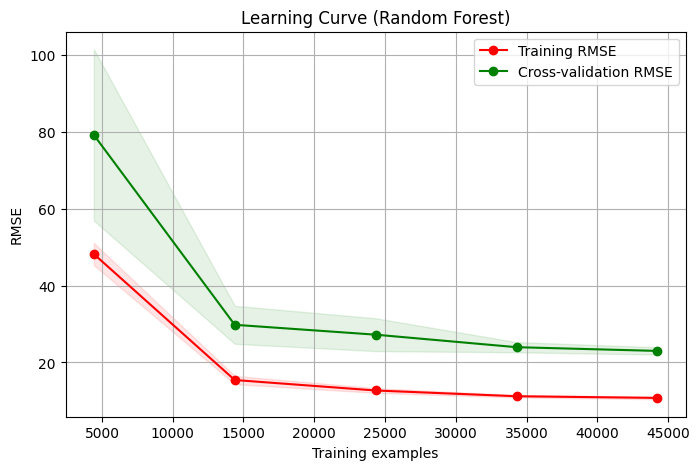

In [ ]:
# Grafica la curva de aprendizaje sin PCA
plot_learning_curve(model_rf, "Learning Curve (Random Forest)", X_train, y_train, cv=5, n_jobs=2)

plt.show()

XGBRegressor

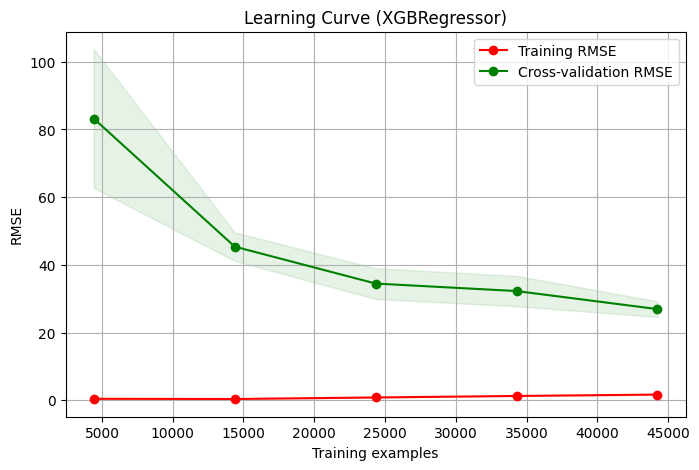

In [ ]:
plot_learning_curve(model_XBG, "Learning Curve (XGBRegressor)", X_train, y_train, cv=5, n_jobs=2)

plt.show()

PCA + Random Forest

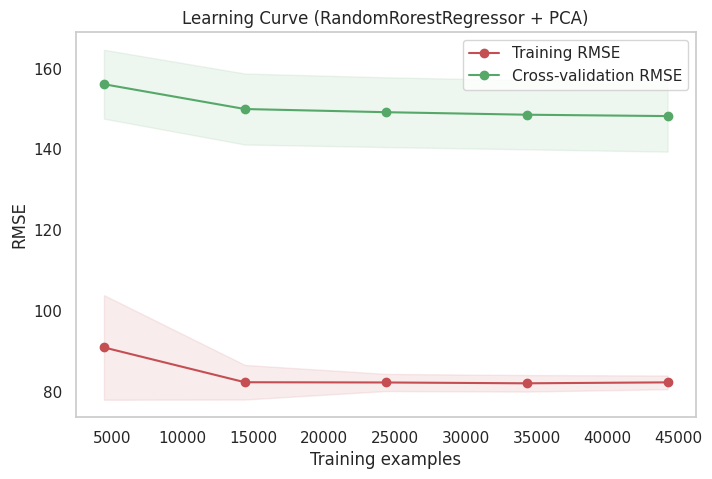

In [ ]:
plot_learning_curve(pipeline, "Learning Curve (RandomRorestRegressor + PCA)", X_train, y_train, cv=5, n_jobs=-1)

plt.show()

PCA + XGBRegressor

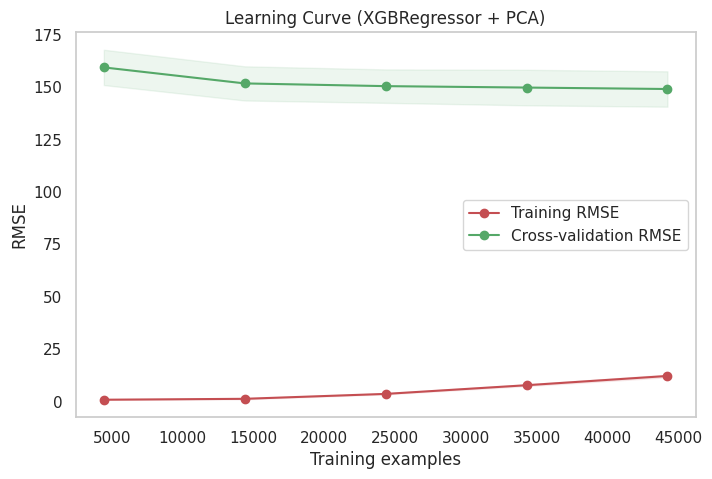

In [ ]:
plot_learning_curve(pipeline, "Learning Curve (XGBRegressor + PCA)", X_train, y_train, cv=5, n_jobs=-1)

plt.show()